# Introduction

What we did in this notebook is selecting a small part of the amazon dataset and use it to test the methods we implemented.

We tried to write code which makes use of Spark SQL, however due to the limitated competences of certain members of the group we weren't always able to provide efficient code. This issue will be resolved in Milestone 3.

Please also note that due to time constraints and cluster overload we weren't able to properly test our methods on the cluster.

# Import/Helpers

In [43]:
import os
import findspark
#os.environ['SPARK_HOME'] = '/opt/apache-spark'
# os.environ['SPARK_HOME'] = '/usr/local/Cellar/apache-spark/2.2.0/libexec/'
findspark.init()
from pyspark import SQLContext, SparkContext, SparkConf
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.mllib.stat import Statistics as S
import json
import numpy as np
import scipy.stats as stats
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark_dist_explore import hist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def correlation(df, col1, col2, method='pearson'):
    rdd1 = df.select(col1).rdd.map(lambda x: x[0])
    rdd2 = df.select(col2).rdd.map(lambda x: x[0])
    return S.corr(rdd1, rdd2, method)

Creation of a Spark contest.

In [3]:
memory = '2g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args
sc = SparkContext()
sqlContext = SQLContext(sc)

# Questions

We load the data from the json file. The data is a small subset containing only items from the following categories:
"Baby", "Automotive" and "Grocery and Gourmet Food". We will use this dataset on our local machine to qualitatively manipulate the data. 

In [4]:
#df_review = sqlContext.read.json("reviews_auto_baby_grocery.json")
#df_review = sqlContext.read.json("datasets/data.json")
#df_review.write.parquet("data.parquet")

In [4]:
# df_review = sqlContext.read.json("reviews_auto_baby_grocery.json")
df_review = sqlContext.read.parquet("data.parquet")
num_reviews = df_review.count()

Here we load the product's metadata.

In [5]:
 #meta_df = sqlContext.read.json("meta_auto_baby_grocery.json")
meta_df = sqlContext.read.parquet("metadata.parquet")
#meta_df = sqlContext.read.json("datasets/metadata.json")

Setup for parquet file:

In [ ]:
# We flatten the meta dataframe
# No need to run it, already checked...
def flatten(salesRank):
    if salesRank == None:
        return None, None
    else:
        for category, rank in salesRank.asDict().items():
            if rank != None:
                return (category, rank)
    return None, None
flatten = udf(flatten, StructType([StructField("category", StringType()), StructField("rank", IntegerType())]))
df_flattened = meta_df.withColumn("salesRank", flatten("salesRank"))
df_flattened = df_flattened.drop("_corrupt_record")
df_flattened = df_flattened.select(list(set(df_flattened.schema.names) - set(["salesRank", "related"]))+ ["salesRank.*", "related.*"])
df_flattened.write.parquet("metadata.parquet")

In [ ]:
meta_df

In [ ]:
# No need to run it, already checked...

# We check that there is no metadata with two ranks
def not_one_or_none(salesRank):
    count = 0
    # If no rank, then false
    if salesRank == None:
        return 0
    for category, rank in salesRank.asDict().items():
        if rank != None:
            count += 1
    return int(count != 1 and count != 0)
not_one_or_none = udf(not_one_or_none, IntegerType())
not_one_or_none = meta_df.withColumn("exactly_one", not_one_or_none("salesRank")).agg(F.sum("exactly_one").alias("sum")).head()[0]
print("There is %.d article with not exactly one category for a rank"%not_one_or_none)

We filter the salesRank to have only ranked products. There is two possiblity, either the salesRank is completely none, either the categories are all None. we take care of both cases.

In [6]:
filtered_meta_df = meta_df.dropna(subset=['rank', "category"])
filtered_meta_df.count()

6151598

In [11]:
good_reviews = df_review.filter(df_review['overall'] > 3)
bad_reviews = df_review.filter(df_review['overall'] <= 3)

In [12]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.clustering import LDA

tokenizer = Tokenizer(inputCol="reviewText", outputCol="raw")
tokenized = tokenizer.transform(bad_reviews)

remover = StopWordsRemover(inputCol="raw", outputCol="words")
clean_text = remover.transform(tokenized)

cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize = 1000)
cvmodel = cv.fit(clean_text)
featurizedData = cvmodel.transform(clean_text)
 
vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)
 
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData) # TFIDF

# Generate 25 Data-Driven Topics:
# "em" = expectation-maximization 
lda = LDA(k=25, seed=123, optimizer="em", featuresCol="features")
ldamodel = lda.fit(rescaledData)
 
model.isDistributed()
model.vocabSize()
 
ldatopics = ldamodel.describeTopics()
# Show the top 25 Topics
ldatopics.show(25)

KeyboardInterrupt: 

# Time analysis

In [8]:
df_time = df_review.withColumn("year", F.from_unixtime(df_review.unixReviewTime, "yyyy"))
df_time = df_time.withColumn("month", F.from_unixtime(df_review.unixReviewTime, "MM"))

In [21]:
avg_year = df_time.groupBy("year").agg(F.mean("overall").alias("avg_rating"), F.stddev("overall").alias("std_rating")).toPandas()
avg_year.sort_values(by='year').set_index("year").plot()

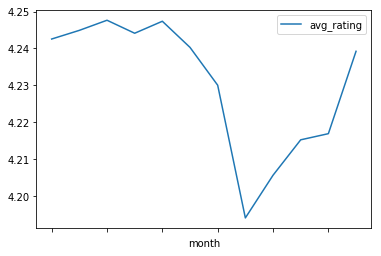

In [27]:
avg_year = df_time.groupBy("month").agg(F.mean("overall").alias("avg_rating"), F.stddev("overall").alias("std_rating")).toPandas()
avg_year.sort_values(by='month').set_index("month").drop("std_rating", axis=1).plot();

In [49]:
from datetime import datetime
weekDay = udf(lambda x: datetime.fromtimestamp(x).strftime("%A"), StringType())
avg_weekday = df_review.withColumn("weekDay", day("unixReviewTime")).groupBy("weekDay").agg(F.mean("overall").alias("avg_rating"), F.stddev("overall").alias("std_rating")).toPandas()

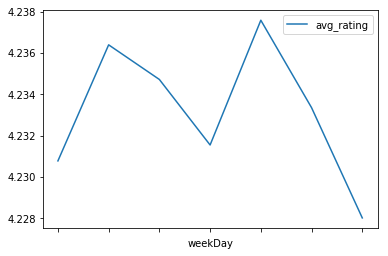

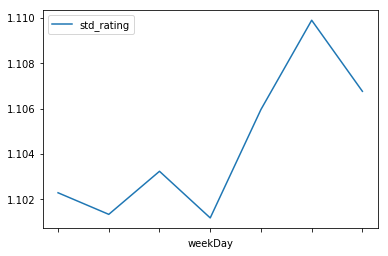

In [50]:
avg_weekday["weekDay"] = pd.Categorical(avg_weekday['weekDay'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)
avg_weekday = avg_weekday.set_index("weekDay").sort_index()
plt.figure(0)
avg_weekday.drop("std_rating", axis=1).plot();
plt.figure(1)
avg_weekday.drop("avg_rating", axis=1).plot();

## Question 1: review quantity vs quality 

Here we explore some metrics related to reviews: a quantitative one - the number of words per review - and a qualitative one - the helpfulness of a review. 

### Word count
Here we count the number of word in a certain review.

In [7]:
wordCount = F.udf(lambda text: len(text.split(" ")), T.IntegerType())

df = df_review.withColumn('wordcount', wordCount(df_review["reviewText"]))

In [13]:
df_reviewer = df.groupBy("reviewerID").agg(F.mean("wordcount").alias("mean_wc"), F.stddev("wordcount").alias("std_wc"), F.mean("overall").alias("mean_rating"))
df_reviewer.head(1)

[Row(reviewerID='A1PHR2L45UYEP8', mean_wc=105.34782608695652, std_wc=65.96875266747443, mean_rating=4.173913043478261)]

In [27]:
pandas_df = df_reviewer.toPandas()
pandas_df.set_index("reviewerID", inplace=True)

In [21]:
data = df_reviewer.rdd.map(lambda x: list(x.asDict().values()))\
    .collect()
data = np.array(data)

In [31]:
pandas_df.corr()

,mean_wc,std_wc,mean_rating
mean_wc,1.000000,0.846044,-0.129266
std_wc,0.846044,1.000000,-0.131520
mean_rating,-0.129266,-0.131520,1.000000


In [20]:
row = df_review.head()
list(row.asDict().values())

['0385500521',
 [1, 2],
 3.0,
 "The author's fundamental hypothesis, that Western armies are more effective warriors than any other, because the Western armies are free (or, perhaps I should say, are not living under authoritarian governments), has remained with me. I have considered the hypothesis during several subsequent reads. For instance, I am considering it in light of what I am reading about WWI. Though initially hesitant to do so (particularly the French), the French and English armies eventually adapted to their conditions, as they should be want to do, according to Hanson's hypothesis. In this case I am drawn to the hypothesis.However, I am, at the same time, dissuaded from believing the theory by the same treatise about WWI. The Russians, though not exactly living in a free society under the Czar, had to overcome tremendous logistical obstacles to present a credible threat to the Germans. I can't help but doubt the ingenuity shown by individuals in the Russian Army in getti

In [7]:
df = df.select(["overall", "wordcount"])
data = df.rdd.map(lambda x: (x[0], x[1]))\
    .collect()
data = np.array(data)

In [10]:
import scipy.stats as stats
import mord
ordinal_ridge = mord.OrdinalRidge()
X = data[:, 1].reshape(-1, 1)
y = data[:, 0].reshape(-1, 1)
ordinal_ridge.fit(X, y)
sse = np.sum((ordinal_ridge.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
se = np.array([
    np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
    for i in range(sse.shape[0])
    ])

t = ordinal_ridge.coef_ / se
p = 2 * (1 - stats.t.cdf(np.abs(t), y.shape[0] - X.shape[1]))
ordinal_ridge.coef_, p

(array([[-0.00039671]]), array([[ 0.]]))

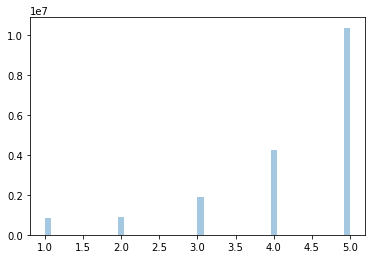

In [13]:
sns.distplot(data[:, 0], kde=False)

In [21]:
mask = data[:, 1] > np.percentile(data[:, 1], 99)

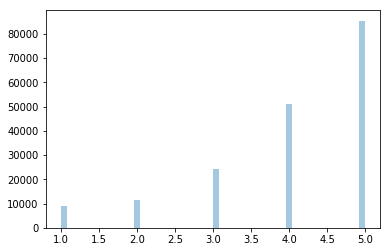

In [22]:
sns.distplot(data[mask][:, 0], kde=False)

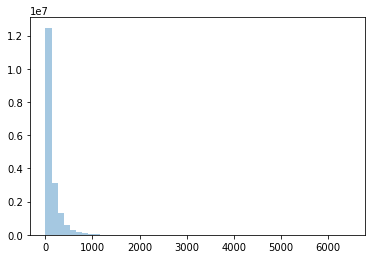

In [14]:
sns.distplot(data[:, 1], kde=False)

/home/raph/.conda/envs/idp/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/home/raph/.conda/envs/idp/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


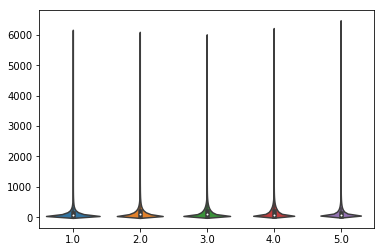

In [17]:
sns.violinplot(x=data[:,0], y=data[:,1])

In [20]:
import scipy.stats as stats
stats.wilcoxon(data[:,0], data[:, 1])

WilcoxonResult(statistic=648618786.0, pvalue=0.0)

In [19]:
np.unique(data[:,0])

array([ 1.,  2.,  3.,  4.,  5.])

In [25]:
del data

In [14]:
df.select("wordcount").describe().show()

+-------+------------------+
|summary|         wordcount|
+-------+------------------+
|  count|          18186733|
|   mean| 134.3130121831117|
| stddev|171.91125779517296|
|    min|                 1|
|    max|              6465|
+-------+------------------+



In [12]:
# wordCount = F.udf(lambda text: len(text.split(" ")), T.IntegerType())

# df = df_review.withColumn('wordcount', wordCount(df_review["reviewText"]))

df.select("wordcount").describe().show()
overall = df.select("overall").rdd.map(lambda x: x[0])
wordcount = df.select("wordcount").rdd.map(lambda x: x[0])
pearson_corr = correlation(df, "overall", "wordcount", method='pearson')
spearman_corr = correlation(df, "overall", "wordcount", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

+-------+------------------+
|summary|         wordcount|
+-------+------------------+
|  count|          18186733|
|   mean| 134.3130121831117|
| stddev|171.91125779517296|
|    min|                 1|
|    max|              6465|
+-------+------------------+

The pearson correlation is -0.062 and the spearman is -0.129


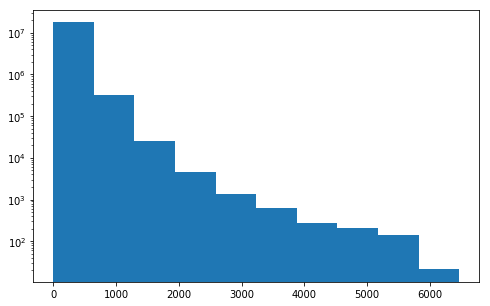

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df.select("wordcount"), log=True);
# pearson_corr = correlation(df.filter(df.wordcount > 1000), "overall", "wordcount", method='pearson')
# spearman_corr = correlation(df.filter(df.wordcount > 1000), "overall", "wordcount", method='spearman')
# print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

### Helpfulness
We get the "helpfulness" of a review by computing the ratio of people that found a review helpful and those that voted. If we have no data, we simply put -1 as a ratio.

In [6]:
df_review = df_review.withColumn("helpfulness", F.when(df_review.helpful.getField(1) > 0, df_review.helpful.getField(0)/df_review.helpful.getField(1)).otherwise(-1))

In [7]:
df_review.filter(df_review["helpfulness"] >= 0.0).select("helpfulness").describe().show()

+-------+-----------------+
|summary|      helpfulness|
+-------+-----------------+
|  count|          9401162|
|   mean|0.722155372460653|
| stddev|  0.3505765314957|
|    min|              0.0|
|    max|              8.0|
+-------+-----------------+



There seems to have some discrepancies amongst the ratio, since the max is at 2.0. We will check that it does not occur too often and may drop the data in the future.

In [8]:
df_review.filter(df_review["helpfulness"] > 1.0).select("helpful").count()

25

In [9]:
df_review_filtered = df_review.filter((df_review["helpfulness"] >= 0.0) & (df_review["helpfulness"] <= 1.0))

In [27]:
data = df_review_filtered\
    .select("overall", "helpfulness")\
    .rdd.map(lambda x: (x[0], x[1]))\
    .collect()
data = np.array(data)

In [28]:
stats.ranksums(data[:, 0], data[:, 1])

RanksumsResult(statistic=3630.0517801282044, pvalue=0.0)

In [18]:
import scipy.stats as stats
import mord
ordinal_ridge = mord.OrdinalRidge()
X = data[:, 1].reshape(-1, 1)
y = data[:, 0].reshape(-1, 1)
ordinal_ridge.fit(X, y)
sse = np.sum((ordinal_ridge.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
se = np.array([
    np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
    for i in range(sse.shape[0])
    ])

t = ordinal_ridge.coef_ / se
p = 2 * (1 - stats.t.cdf(np.abs(t), y.shape[0] - X.shape[1]))
ordinal_ridge.coef_, p

(array([[ 0.9771911]]), array([[ 0.]]))

In [29]:
stats.pearsonr(data[:, 0], data[:, 1])

(0.27540777233401909, 0.0)

Since only two reviews have problems, we will simply ignore them.

We then look at some distribution of helpfulness and rating.

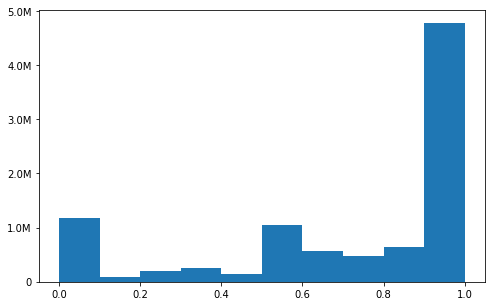

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_review_filtered.select("helpfulness"));

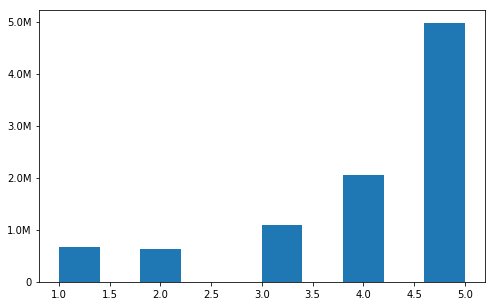

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_review_filtered.select("overall"));

In [12]:
correlation(df_review_filtered, "overall", "helpfulness")

0.2754077723340075

With only these three metrics we aren't able to draw any meaningful conclusion.

In [13]:
mean_helpfulness_df = df_review_filtered.groupBy('reviewerID').agg(F.mean("helpfulness").alias("helpfulness"), F.mean("overall").alias("overall"))
data = mean_helpfulness_df\
    .select("overall", "helpfulness")\
    .rdd.map(lambda x: (x[0], x[1]))\
    .collect()
data = np.array(data)
stats.pearsonr(data[:,0], data[:, 1])

(0.25795961383403848, 0.0)

In [54]:
mean_helpfulness_df = df_review_filtered.groupBy('asin').agg(F.mean("helpfulness").alias("helpfulness"), F.mean("overall").alias("overall"), F.stddev("overall").alias("std_overall"))
data = mean_helpfulness_df\
    .select("overall", "helpfulness")\
    .rdd.map(lambda x: (x[0], x[1]))\
    .collect()
data = np.array(data)
stats.pearsonr(data[:,0], data[:, 1])

(0.31337405033599253, 0.0)

In [55]:
data = meta_df.dropna(subset=["rank"]).select('asin', 'rank').join(mean_helpfulness_df, 'asin').toPandas()
# data = np.array(data)

In [57]:
data.corr()

,rank,helpfulness,overall,std_overall
rank,1.000000,0.077486,0.006359,-0.043353
helpfulness,0.077486,1.000000,0.307072,-0.319635
overall,0.006359,0.307072,1.000000,-0.694842
std_overall,-0.043353,-0.319635,-0.694842,1.000000


In [34]:
print(stats.pearsonr(data[:,0], data[:, 1]))
print(stats.pearsonr(data[:,0], data[:, 2]))

(0.0063591142455847165, 3.2883160174460342e-05)
(0.077485553719954664, 0.0)


Here we compute the correlation between a product ranking and -respectively - the number of reviews it has, the average of the reviews helpfulness, the average of the reviews ranking.

In [13]:
output_df = meta_df[['asin', 'rank']]

joined_df = meta_df.join(df_review, 'asin')
grouped_df = joined_df.groupBy('asin')

review_count_df = grouped_df.count()
mean_helpfulness_df = grouped_df.mean('helpfulness', 'overall')
output_df = output_df.join(review_count_df, 'asin').join(mean_helpfulness_df, 'asin')
rank_count_correlation = output_df.corr('rank', 'count', method='pearson')
rank_helpfulness_correlation = output_df.corr('rank', 'avg(helpfulness)', method='pearson')
rank_overall_correlation = output_df.corr('rank', 'avg(overall)', method='pearson')
print(rank_count_correlation, rank_helpfulness_correlation, rank_overall_correlation)

-0.03279435475548705 0.10355802500411367 -0.021187929473576554


## Question 2: influence of reviewer personality

We get the count of review of distinct article per reviewer and filter those that have less than 5 review.

In [14]:
df_count = df_review.groupBy("reviewerID").agg(F.countDistinct("asin").alias('count')).filter("`count` >= 5")

We get all reviews of reviewers with more than 5 articles.

In [15]:
df_filtered = df_review.join(df_count, on='reviewerID').drop('count')
num_five_reviews = df_filtered.count()
print("We have %.d, i.e. %.3f%% of review who belongs to reviewer with 5 or more reviews"%(num_five_reviews, num_five_reviews/num_reviews))

We have 18186733, i.e. 1.000% of review who belongs to reviewer with 5 or more reviews


We compute the average grade for each reviewer.

In [16]:
average_std_score = df_review.groupBy("reviewerID").agg(F.avg("overall").alias("mean"), F.stddev("overall").alias("std"))
average_std_score.cache().count()

1116318

Here are some statistic concerning the average grade for each reviewer.

The first row contains the total number of reviewer considered.

The second row contains the mean of the reviewers' averages grades (left) and the standard deviation of said mean (right).

The third row contains the mean of the reviewers' standard deviations (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's lower grades (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's higher grades (left) and the standard deviation of said mean (right).

In [17]:
average_std_score.select("mean", "std").describe().show()

+-------+------------------+------------------+
|summary|              mean|               std|
+-------+------------------+------------------+
|  count|           1116318|           1116318|
|   mean| 4.237445234962943|0.8689434742290486|
| stddev|0.6430152136139993|0.5406193821169274|
|    min|               1.0|               0.0|
|    max|               5.0|2.1908902300206647|
+-------+------------------+------------------+



We then plot the average grade for each reviewer through histograms, with the grade on the x-axys and the number of reviewers who have such mean ranking on the y-axis.

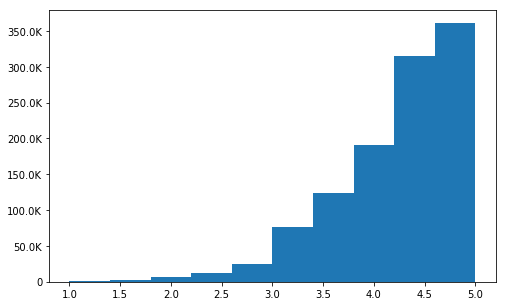

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, average_std_score.select("mean"));

It can be noted that reviewers tend to give high ratings.

We then plot the average standard deviation for each reviewer through histograms, with the grade on the x-axys and the number of reviewers who have such average standard deviation on the y-axis.

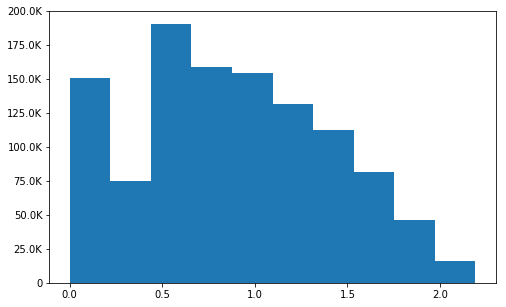

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, average_std_score.select("std"));

It can be noted that the majority of reviewers tend to have either a very small standard deviation (0-0.25) or a standard deviation between 0.5 and 1.5. The number of people with an higher standard deviation are sensibily less.

Here, we look at the mean of the ratings given by reviewer with small (<0.25) standard deviation.
We also look at what percentage of reviewer they correspond.

There is 13.73% of reviewer with std < 0.25


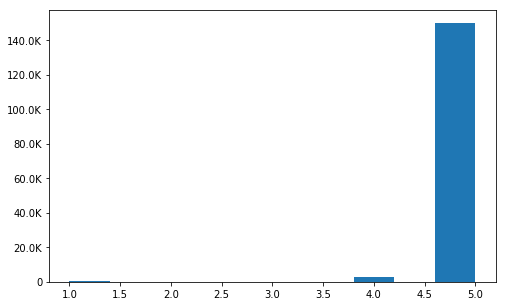

In [20]:
print("There is %.2f%% of reviewer with std < 0.25"%(average_std_score.filter(average_std_score.std < 0.25).count()/average_std_score.count()*100))
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, average_std_score.filter(average_std_score.std < 0.25).select("mean"));

It can be noted that people with a small standard deviation, i.e. people who tend to always give the same rating, tend to give only very high rating (>4.5).

In conclusion, we have hints that there's a certain bias related to reviewers' personality and habits. 
The fact that the mean of the average reviewer rating is so high for example could make us think that people tend to rate the product they're satisfied with and not those they're unsastisfied with.
The fact that the reviewers with little standard deviation tend to give high ratings also speaks in that direction.

## Question 3: Brand fidelity/hate

We load the metadata datas and only keep the article number and the brand that are not null, since we are interested in brands.

We then join the dataframe of reviews with the metadata and display some stats.

In [22]:
# df_meta = sqlContext.read.json("meta_auto_baby_grocery.json")
df_meta_brand = meta_df.select("asin", "brand").dropna()

df_with_brand = df_filtered.join(df_meta_brand, on='asin')
num_reviews_with_brand = df_with_brand.count()

print("We have %.d, which represents %.3f%% of review with a brand and who belongs to reviewer with 5 or more reviews"%(num_reviews_with_brand, num_reviews_with_brand/num_reviews))
print("We have %.3f%% of review amongst those who belongs to reviewer with 5 or more reviews that have a brand "%(num_reviews_with_brand/num_five_reviews))

We have 3195304, which represents 0.176% of review with a brand and who belongs to reviewer with 5 or more reviews
We have 0.176% of review amongst those who belongs to reviewer with 5 or more reviews that have a brand 


We can see that once again we loose a lot of reviews with this approach, but it is still an interesting number to work with.

Then we group by brand and reviewer, compute some stats and filter out all reviewers that have less than 5 reviews for a specific brand.

In [23]:
df_brand_reviewer = df_with_brand.groupBy(["brand", "reviewerID"]).agg(F.count("overall").alias("count"), F.avg("overall").alias("mean"), F.stddev("overall").alias("std")).filter("`count` >= 5")
brand_reviewers_count = df_brand_reviewer.cache().count()
print("We have %.d brand/reviewers tuples"%(brand_reviewers_count))

We have 27991 brand/reviewers tuples


We then show some stats about the mean and std.

+-------+------------------+------------------+------------------+
|summary|             count|              mean|               std|
+-------+------------------+------------------+------------------+
|  count|             27991|             27991|             27991|
|   mean|10.549819584866563| 4.285022974122227|0.7416057878513868|
| stddev| 18.57718396527397|0.6459028905176771|0.5229705628819817|
|    min|                 5|               1.0|               0.0|
|    max|               794|               5.0|2.1908902300206647|
+-------+------------------+------------------+------------------+



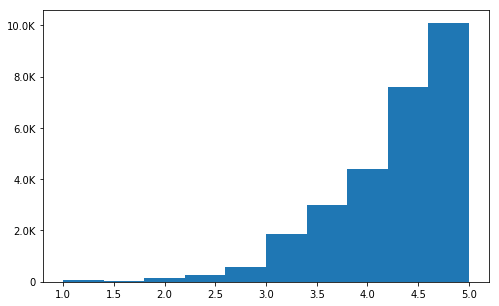

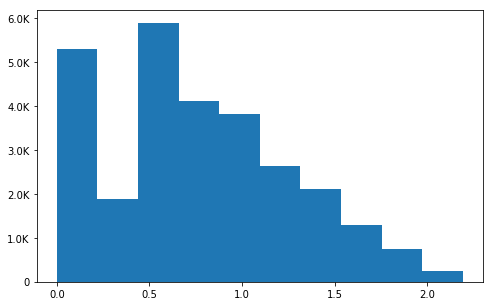

In [24]:
df_brand_reviewer.select("count", "mean", "std").describe().show()
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_brand_reviewer.select("mean"));
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_brand_reviewer.select("std"));

By comparing qualitatively (we will do a more precise analysis in milestone 3) those graphs with the one from Question 2, we can see that the ratings seems to be having less deviation, showing a tendency to love/hate toward a brand.

We try to see if there is an obvious correlation between number of reviews for a brand and the mean rate:

In [25]:
pearson_corr = correlation(df_brand_reviewer, "count", "mean", method='pearson')
spearman_corr = correlation(df_brand_reviewer, "count", "mean", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

The pearson correlation is -0.050 and the spearman is -0.116


At first sight, we cannot see an obvious relationship, however, we will do a more refined analysis in the next milestone.

Compute the total number of products.

In [26]:
total_products = meta_df.count()
total_products

9430088

Compute the ratio between ranked and total products.

In [27]:
ranked_products = meta_df.count()
ranked_products
ratio = ranked_products/total_products
print("ranked_products: " + str(ranked_products) + " total products: " + str(total_products) + " ratio: " + str(ratio))

ranked_products: 9430088 total products: 9430088 ratio: 1.0


We can notice that in this restricted dataset less than one third of the products is ranked, a fact that makes our rank-based analysis less representative. 

We now check that there is exactly one category that has a sales rank.

## Question 4: influence of 'also bought' feature

I'll begin by focusing on the 'bought together' feature and not on the 'also bought' feature right away.
This both because the former is more relevant to the question and because it scales better: 'also bought' tends to be a very long list of products while 'bought together' is usually much shorter and easier to analyze.

In order to answer question 4, it is possible to use the following approach:
1. Find the best ranked products for each category.
2. look at the rank of the products that were bought together with them.
3. draw  qualitative conclusions.

First we select the interesting columns of the metadata dataframe, flattening the hierarchical datastructure in the process.

Then we define a function that allows to find in which category a product has been ranked.

In [7]:
def explode_and_join(column_to_explode):
    q4_meta_df = meta_df.select("asin", "rank", F.explode(column_to_explode).alias("paired_product")).dropna(how='any')
    q4_joined_meta_df = q4_meta_df.alias("df1").join(q4_meta_df.alias("df2").select(F.col("asin").alias("paired_asin"), F.col("rank").alias("paired_rank")), F.col("paired_product") == F.col("paired_asin"), "inner")
    return q4_joined_meta_df

In [29]:
bought_together_df = explode_and_join("bought_together")

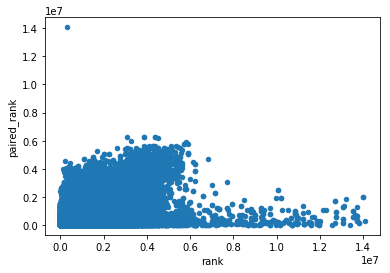

In [30]:
bought_together_df.toPandas().plot.scatter("rank", "paired_rank")

In [31]:
rank_bought_together_correlation = bought_together_df.corr('rank', 'paired_rank', method='pearson')
rank_bought_together_correlation

0.6638457806127336

In [32]:
also_bought_df = explode_and_join("also_bought")

In [33]:
rank_also_bought_correlation = also_bought_df.corr('rank', 'paired_rank', method='pearson')
rank_also_bought_correlation

0.4513344392636174

In [8]:
also_viewed_df = explode_and_join("also_viewed")

In [9]:
also_viewed_df.limit(100).collect()

[Row(asin='0061060003', rank=3044473, paired_product='0061060054', paired_asin='0061060054', paired_rank=2295748),
 Row(asin='0061138495', rank=2705300, paired_product='0061138525', paired_asin='0061138525', paired_rank=3530559),
 Row(asin='0061138495', rank=2705300, paired_product='0061138525', paired_asin='0061138525', paired_rank=3530559),
 Row(asin='0061138517', rank=3098352, paired_product='0061138525', paired_asin='0061138525', paired_rank=3530559),
 Row(asin='0061138517', rank=3098352, paired_product='0061138525', paired_asin='0061138525', paired_rank=3530559),
 Row(asin='0844279528', rank=2048231, paired_product='0071549838', paired_asin='0071549838', paired_rank=1256358),
 Row(asin='0844279528', rank=2048231, paired_product='0071549838', paired_asin='0071549838', paired_rank=1256358),
 Row(asin='0844279528', rank=2048231, paired_product='0071549838', paired_asin='0071549838', paired_rank=1256358),
 Row(asin='0844279528', rank=2048231, paired_product='0071549838', paired_asin='

In [10]:
rank_also_viewed_correlation = also_viewed_df.corr('rank', 'paired_rank', method='pearson')
rank_also_viewed_correlation

0.28586182272141314

It can be noted that products with very different rankings were bought together.
This means that question 4 might indeed make sense, there might be "good" product that improve the sales of "bad" products. As of now "good" means "popular" and bad means "unpopolar", but the definition might change when we delve even further into the data.

## Question 5: rank/review ratio

The approach for question 5 is the following:
1. For each rank category, take the 5 best ranked products
2. look in the review table and see how many review were made for each product
3. Print the values and try to qualitatevely interpet. 

Here we apply the described pipeline.

In [14]:
data = review_count_per_product.rdd.map(lambda x: (x[1], x[2])).collect()

In [18]:
data = np.array(data)

In [22]:
stats.kendalltau(data[:, 0], data[:, 1])

KendalltauResult(correlation=-0.070864654178437361, pvalue=0.0)

In [11]:
q5_meta_df = meta_df.select("asin", "rank").dropna(how='any')
review_count_per_product = q5_meta_df.join(df_review, "asin").groupby("asin", "rank").count()
corr = review_count_per_product.corr("rank", "count", method ='pearson')
corr

-0.026873823134399902

There's doesn't seem to be any correlation between the number of reviews associated to a product and its sales ranking according to these results, which don't hint at a linear relationship between number of reviews and sales.

## Question 6: product categorization

In [ ]:
def explode_categories():
    q6_meta_df = meta_df.select("asin", "rank", F.explode("categories").alias("category")).select("asin", "rank", F.explode("category").alias("category")).dropna(how='any')
    review_count_per_category = q6_meta_df.join(df_review, "asin").groupby("category").count()
    review_count_per_category = review_count_per_category.orderBy("count", ascending = False)
    return review_count_per_category
    
review_count_per_category = explode_categories()
review_count_per_category.show()

# TO DO FOR MILESTONE 3 

## Question 1 

Find metrics allowing to draw meaningful conclusions.

## Question 2

Better quantify the bias of the reviewer by analysing other aspects 

## Question 3

Further delve into the data to produce a coherent conclusion.

## Question 4

Further delve into the data and formally describe the relation between the 'also bought' and 'bought together' features as well as the meaning of a "good" and "bad" product, which as of now is associated to popularity. 
Also substitute the print based approach with a more complex one.

Draw formally correct conclusion with regard to the influence of the 'also_bought' feature on sales.

## Question 5

Confirm the conclusion by working on the whole dataset through the cluster and substitute the print based approach with a more complex one. 

## Question 6 

Confirm the conclusion by working on the whole dataset through the cluster and substitute the dictionary based approach with a more complex one. 

## Refine analysis

Eventually find new question related to reviews and answer them.

## Final Conclusion

produce a clear description of the characteristic of an amazon review: how can review be in interpreted in the complex system that is Amazon?

## Report

sum up the results of the research in a 4-page report.

## Poster

design a poster to present the results of our research.